online method
running stoc_RPCA
shat shape (100, 3200)


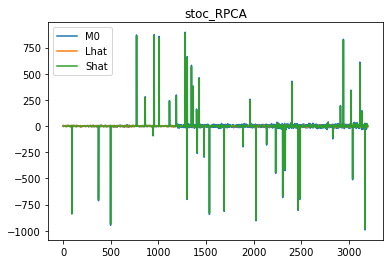

running omwrpca


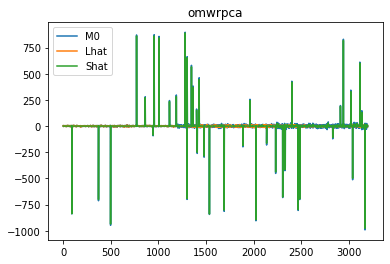

running omwrpca_cp


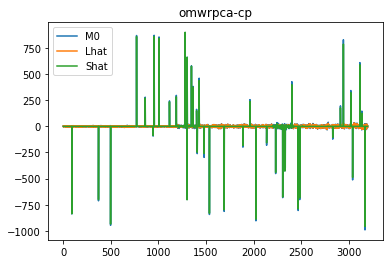

change points detected [1200, 2200]


In [42]:
import pickle
import matplotlib.pyplot as plt
pms = {}
pms['method'] = 'online'

pms['m'] = 100
pms['n'] = 3000

# r vector
pms['rvec'] = [10,50,100]
# rho hyperparam
pms['rho'] = 0.01
pms['n_p'] = 250
pms['r0'] = 5

# number of repititions
pms['nrep'] = 1
pms['seed'] = 12345

pms['burnin'] = 200
pms['win_size'] = 200
pms['track_cp_burnin'] = 200
pms['n_check_cp'] = 20
pms['alpha'] = 0.01
pms['proportion'] = 0.5
pms['n_positive'] = 3
pms['min_test_size'] = 100
pms['tolerance_num'] = 0
pms['factor'] = 1



    
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 22 16:23:42 2016

@author: wexiao
"""
import numpy as np
from timeit import default_timer as timer
import math
import os, sys
sys.path.insert(0, os.path.abspath('..'))

#from rpca.pcp import pcp
from rpca.mwrpca import mwrpca
from rpca.stoc_rpca  import stoc_rpca
from rpca.omwrpca  import omwrpca
from rpca.omwrpca_cp  import omwrpca_cp
from onlineRPCA.simulation.criteria import evaluate
   
def simulation(method, m=400, n=3000, rvec=[10,10,10], rho=0.1, n_p=250, r0=5, nrep=50, seed=1234, 
               burnin=200, win_size=200, track_cp_burnin=100, n_check_cp=20, alpha=0.01, proportion=0.5, n_positive=3, 
               min_test_size=100, tolerance_num=0, factor=1):
    result = [np.nan] * nrep
    run_times = [np.nan] * nrep
    random_state = np.random.get_state()
    
    for rep in range(nrep):
        if rep == 0:
            # seed the generator
            np.random.seed(seed=seed)
        else:
            np.random.set_state(random_state)                
        result[rep] = {}
        run_times[rep] = {}
        
        #simulate the data
        n_piece = n / len(rvec)
        # print('n piece = ', n_piece)
        U0 = []
        for r in rvec:
            # print(f'appending r={r}')
            U0.append(np.random.randn(m, r))
        V0_burnin = np.random.randn(burnin, rvec[0])
        V0 = []
        for r in rvec:
            V0.append(np.random.randn(int(n_piece), r))
        L0 = U0[0].dot(V0_burnin.transpose())
        K = int(math.ceil(float(n)/n_p))  
        Utilde = []
        for k in range(K):
            i = math.floor(k / (n_piece / n_p))
            Utemp = np.random.randn(m,rvec[i])
            Utemp[:,r0:] = 0
            Utilde.append(Utemp)
        for k in range(n):
            i, index_i = math.floor(k / n_piece), math.floor(k % n_piece)
            l, index_l = math.floor(k / n_p), int(k % n_p)

            U0_i, V0_i = U0[i], V0[i]
            U = U0_i + float(index_l + 1) / n_p * Utilde[l]
            # breakpoint()
            
            L0 = np.hstack((L0, U.dot(V0_i[index_i, :]).reshape(m,1)))
            
        S0 = (np.random.uniform(0, 1, size=(m,n + burnin)) < rho).astype(int) * np.random.uniform(-1000, 1000, size=(m,n + burnin))    
        M0 = L0+S0
        # M0 = M0 + np.random.randn(1,3200)*1000
        
        # mydata = np.concatenate((np.random.randn(1200), 0.1*np.random.randn(1000)+1))
        # mydata = np.concatenate((mydata, 0.6*np.random.randn(1000)-2))
        # mydata = mydata.reshape(1,3200)    
        # M0 = mydata
        # print(M0.shape)
        # plt.plot(M0[0])
        # plt.title('M0')
        # plt.show()
        # save random generator state            
        random_state = np.random.get_state()
        
        if method == 'online':
            print('online method')
            ###### stoc_RPCA
            print('running stoc_RPCA')
            start = timer()
            Lhat, Shat, rank, Uhat = stoc_rpca(M0, burnin, lambda1=1.0/np.sqrt(m), lambda2=1.0/np.sqrt(m)*(10**2))
            end = timer()       
            result[rep]['stoc_rpca'] = evaluate(Lhat, Shat, L0, S0, r, U0, burnin)
            run_times[rep]['stoc_rpca'] = end - start
            
            
            plt.clf()
            plt.title("stoc_RPCA")
            plt.plot(M0[0], label = 'M0')
            
            plt.plot(Lhat[0], label='Lhat')
            plt.plot(Shat[0], label='Shat')
            print("shat shape", Shat.shape)
            plt.legend()
            plt.show()
        
            ###### omwrpca 
            print('running omwrpca')
            start = timer()
            Lhat, Shat, rank = omwrpca(M0, burnin, win_size, lambda1=1.0/np.sqrt(m), lambda2=1.0/np.sqrt(m)*(10**2))
            end = timer()
            result[rep]['omwrpca'] = evaluate(Lhat, Shat, L0, S0, r, U0, burnin)
            run_times[rep]['omwrpca'] = end - start
            plt.clf()
            plt.title("omwrpca")
            plt.plot(M0[0], label = 'M0')
            plt.plot(Lhat[0], label='Lhat')
            plt.plot(Shat[0], label='Shat')
            plt.legend()
            plt.show()
            
            #omwrpca_cp
            print('running omwrpca_cp')
            start = timer()
            Lhat, Shat, rank, cp, num_sparses = omwrpca_cp(M0, burnin, win_size, track_cp_burnin, n_check_cp, alpha, proportion, n_positive, min_test_size, 
                                                tolerance_num=tolerance_num, lambda1=1.0/np.sqrt(m), lambda2=1.0/np.sqrt(m)*(10**2), factor=1)
            
            # print(f"num sparses = {sum(num_sparses)}")
            plt.clf()
            
            plt.title("omwrpca-cp")
            plt.plot(M0[0], label = 'M0')
            plt.plot(Lhat[0], label='Lhat')
            plt.plot(Shat[0], label='Shat')
            plt.legend()
            plt.show()
            print('change points detected', cp)
            end = timer()
            result[rep]['omwrpca_cp'] = evaluate(Lhat, Shat, L0, S0, r, U0, burnin)
            result[rep]['omwrpca_cp: rank'] = rank
            result[rep]['omwrpca_cp: cp'] = cp
            run_times[rep]['omwrpca_cp'] = end - start
     

    # combine the result    
    sim_result = {}
    sim_result['result'] = result
    sim_result['run_times'] = run_times
    
    return sim_result



results = simulation(method=pms['method'], m=pms['m'], n=pms['n'], 
    rvec=pms['rvec'], rho=pms['rho'], n_p=pms['n_p'], r0=pms['r0'], nrep=pms['nrep'], seed=pms['seed'], 
    burnin=pms['burnin'], win_size=pms['win_size'], track_cp_burnin=pms['track_cp_burnin'], n_check_cp=pms['n_check_cp'], 
    alpha=pms['alpha'], proportion=pms['proportion'], n_positive=pms['n_positive'], min_test_size=pms['min_test_size'], 
    tolerance_num=pms['tolerance_num'], factor=pms['factor'])
    
    


In [43]:
results['result'][0]['stoc_rpca']

,t,error_L,error_S,false_S
0,1,0.779318,0.012103,0
1,2,0.710459,0.010841,0
2,3,0.789098,0.011277,0
3,4,0.783097,0.011045,0
4,5,0.722999,0.014641,0
...,...,...,...,...
2995,2996,0.902884,0.045891,38861
2996,2997,0.902884,0.045914,38894
2997,2998,0.902929,0.045940,38929
2998,2999,0.902942,0.045947,38957


In [44]:
results['result'][0]['omwrpca']

,t,error_L,error_S,false_S
0,1,0.892856,0.011541,0
1,2,0.793751,0.011545,0
2,3,0.635706,0.011273,0
3,4,0.621490,0.011589,0
4,5,0.625635,0.016374,0
...,...,...,...,...
2995,2996,0.802166,0.040063,32011
2996,2997,0.802102,0.040073,32035
2997,2998,0.802141,0.040092,32069
2998,2999,0.802126,0.040094,32085


In [45]:
results['result'][0]['omwrpca_cp']

,t,error_L,error_S,false_S
0,1,0.892856,0.011541,0
1,2,0.793751,0.011545,0
2,3,0.635706,0.011273,0
3,4,0.621490,0.011589,0
4,5,0.625635,0.016374,0
...,...,...,...,...
2995,2996,0.336548,0.039581,24162
2996,2997,0.336515,0.039581,24163
2997,2998,0.336436,0.039581,24164
2998,2999,0.336387,0.039574,24164


In [37]:
# understanding data simulation
n = 3000
rvec = [10,50,25]
m = 400
burnin = 200
n_p = 250
rho = 0.01
r0 = 5

n_piece = n / len(rvec)
# print('n piece = ', n_piece)
U0 = []
for r in rvec:
    # print(f'appending r={r}')
    U0.append(np.random.randn(m, r))
V0_burnin = np.random.randn(burnin, rvec[0])
V0 = []
for r in rvec:
    V0.append(np.random.randn(int(n_piece), r))
L0 = U0[0].dot(V0_burnin.transpose())
K = int(math.ceil(float(n)/n_p))  
Utilde = []
for k in range(K):
    i = math.floor(k / (n_piece / n_p))
    Utemp = np.random.randn(m,rvec[i])
    Utemp[:,r0:] = 0
    Utilde.append(Utemp)
for k in range(n):
    i, index_i = math.floor(k / n_piece), math.floor(k % n_piece)
    l, index_l = math.floor(k / n_p), int(k % n_p)

    U0_i, V0_i = U0[i], V0[i]
    U = U0_i + float(index_l + 1) / n_p * Utilde[l]
    # breakpoint()
    
    L0 = np.hstack((L0, U.dot(V0_i[index_i, :]).reshape(m,1)))
    
S0 = (np.random.uniform(0, 1, size=(m,n + burnin)) < rho).astype(int) * np.random.uniform(-1000, 1000, size=(m,n + burnin))    
M0 = L0+S0

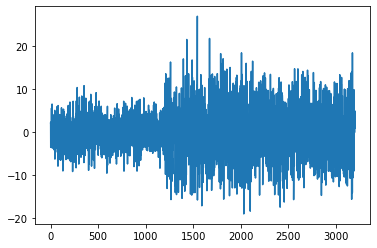

In [40]:

plt.plot(L0[1,:])
plt.show()

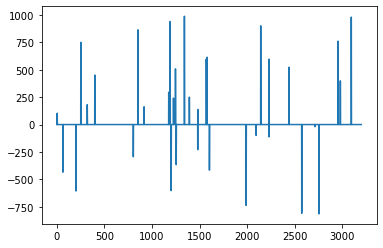

In [41]:
plt.plot(S0[1,:])
plt.show()

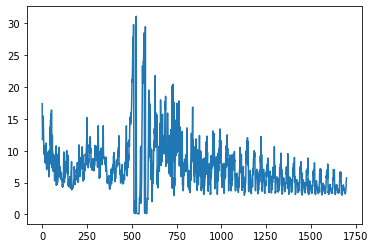

(1700,)


In [47]:
import pandas as pd
method=pms['method']

rho=pms['rho']
n_p=pms['n_p']
r0=pms['r0']
nrep=pms['nrep']
seed=pms['seed']
burnin=pms['burnin']
win_size=pms['win_size']
track_cp_burnin=pms['track_cp_burnin']
n_check_cp=pms['n_check_cp']
alpha=pms['alpha']
proportion=pms['proportion']
n_positive=pms['n_positive']
min_test_size=pms['min_test_size']
tolerance_num=pms['tolerance_num']
factor=pms['factor']

fileName = "data/torque.xlsx"
torqueDataFrame = pd.read_excel(fileName)
# print(torqueDataFrame)      # 3440*2

torqueData = np.asarray(torqueDataFrame)
torqueData = torqueData[:,1]

# mydata = np.concatenate((np.random.randn(1000), np.random.randn(1000)+5))
# mydata = np.concatenate((mydata, np.random.randn(1000)-3))

mydata = torqueData[1500:3200]
plt.plot(mydata)
plt.show()

print(mydata.shape)
# mydata = np.resize(mydata, (1,len(mydata)))
# print(mydata.shape)

window_size = 100
X = np.zeros((window_size,len(mydata)-window_size+1))

for i in range(len(mydata)-window_size+1):
    X[:,i] = mydata[i:i+window_size]
    
Lhat, Shat, rank, cp, num_sparses = omwrpca_cp(X, burnin, win_size, track_cp_burnin, n_check_cp, alpha, proportion, n_positive, min_test_size, 
                                                tolerance_num=tolerance_num, lambda1=1.0/np.sqrt(m), lambda2=1.0/np.sqrt(m)*(10**2), factor=1)
            

In [48]:
cp

[]